# SPICED ACADEMY  //  WEEK 07  //  TEMPERATURE FORECASTING

---

# 0. Set Up

In [444]:
''' Essentials '''
import pandas as pd
import numpy as np
import random
import time

''' Plotting '''
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plt.rcParams['figure.figsize'] = (18, 4)

''' Feature Engineering '''
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

''' Modelling '''
from sklearn.linear_model import LinearRegression

''' Hyperparameter Optimization '''
from sklearn.model_selection import TimeSeriesSplit

In [474]:
plot = True

---

# 1. Business Goal
Develop a predictive model for weather using past data. 

---

# 2. Get Data

In [476]:
df = pd.read_csv('data/TG_STAID002759.csv', na_values='-9999', parse_dates=['date'], index_col=['date'])
df = df.drop(['souid','q_tg'], axis=1)

---

# 3. Train-Test Split

## 3.a. Removing NAs before Train-Test Splitting

In [447]:
''' 
Train-Test split is not randomly defined, NAs are checked first to ensure 75% / 25% split.
195 rows of temperature data are NAs
'''

df['tg'].isna().sum()

195

In [448]:
''' NAs span from 1945-04-25 to 1945-11-05. Imputing will not suffice, so data prior to 1946 will be dropped. ''' 

df_nas = df[df['tg'].isna()==True].index
print(df_nas.min(), df_nas.max())

1945-04-25 00:00:00 1945-11-05 00:00:00


In [449]:
''' Data prior to 1946 is dropped to remove NAs. '''
df = df[df.index>='1946-01-01']

In [450]:
''' Checking for 0 NAs. '''

df['tg'].isna().sum()

0

## 3.b. Train-Test Splitting Remaining Rows

In [451]:
''' To keep 1/5 of data for testing '''
df['souid'].groupby(df.index.year).count().sum() * (4/5)

22133.600000000002

In [452]:
'''  '''
samples_per_year = df['souid'].groupby(df.index.year).count()
cum_samples_per_year = np.cumsum(samples_per_year)
cum_samples_per_year[cum_samples_per_year < 23000][-3:]

date
2005    21915
2006    22280
2007    22645
Name: souid, dtype: int64

In [453]:
df_train = df[df.index.year < 2006]
df_test = df[df.index.year >= 2006]

In [454]:
X = np.reshape(df_train.index, (-1,1))
y = df_train['tg']

---

# 4. Explore Data

In [455]:
if plot: df_train['tg'].plot()

<AxesSubplot:xlabel='date'>

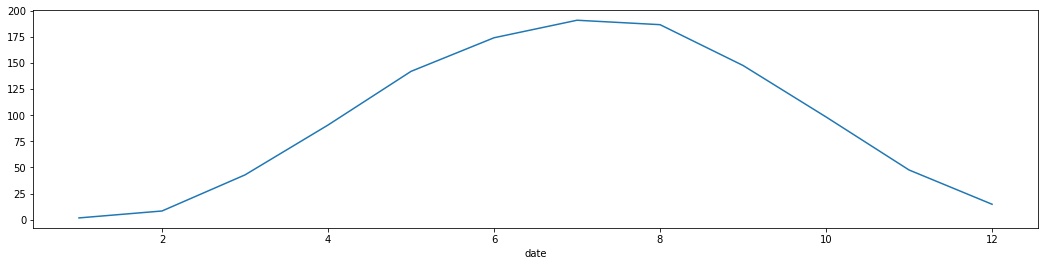

In [456]:
df_train['tg'].groupby(df_train.index.month).mean().plot()

In [457]:
# X = df[['timestep']]
# y = df['tg']

In [458]:
# m0 = LinearRegression()
# m0.fit(X,y)
# df['trend'] = m0.predict(X)

In [459]:
# print(m0.coef_, m0.intercept_)

In [460]:
# df[['tg','trend']].plot()

---

# 5. Feature Engineering

## 5.a. Feature Engineering Execution

In [461]:
df

,souid,tg,q_tg
date,,,
1946-01-01,127488,-34.0,0
1946-01-02,127488,-30.0,0
1946-01-03,127488,-28.0,0
1946-01-04,127488,-27.0,0
1946-01-05,127488,14.0,0
...,...,...,...
2021-09-26,111448,189.0,0
2021-09-27,111448,180.0,0
2021-09-28,111448,157.0,0


### 5.a.i. FunctionTransformer

In [462]:
''' Defining FunctionTransformer functions. '''

def drop_cols(df):
    ''' Drops SOUID and Q_TG columns. '''

    df = df.drop(['trend_seasonal','remainder'], axis=1)
    return df



# sub function in remove_trend_seasonal
def timestep_detrend(df):
    ''' Adds timestep column to de-trend y. '''

    df['timestep'] = list(range(len(df)))
    return df


# sub function in remove_trend_seasonal
def ohe_months_deseasonal(df):
    ''' One-hot-encodes months to de-seasonalize. '''
    
    df_month = pd.get_dummies(data=df.index.month, drop_first=True, prefix='month').set_index(df.index)
    df = df.join(df_month)
    return df



def remove_trend_seasonal(df):
    ''' Creates new y column removing trend and seasonality. '''
    
    df = timestep_detrend(df)
    df = ohe_months_deseasonal(df)
    
    X = df.drop(['tg'], axis=1)
    y = df['tg']

    m1 = LinearRegression()
    m1.fit(X, y)
    df['trend_seasonal'] = m1.predict(X)

    df['remainder'] = df['tg'] - df['trend_seasonal']

    return df



def lag(df, n=3):
    ''' Creates lag functions for lags 1 to n. Drops NAs '''
    
    for iter in range(1,n+1):
        df[f'lag{iter}'] = df['remainder'].shift(iter)
    
    # Drops NAs generated through lags.
    df = df.dropna()

    return df



def standard_scale(x):
    '''  '''  
    
    x_scaled = (x - x.mean())/x.std()
    
    return x_scaled



def scale_columns (df, columns_list):
    ''' Splits dataframe into y (tg) and X vriables. '''
    
    for column in columns_list:
        df[column] = standard_scale(df[column])

    return df

In [463]:
''' Calling FunctionTransformer functions. '''

get_no_trend_seasonal = FunctionTransformer(remove_trend_seasonal)
get_lags = FunctionTransformer(lag)
get_scaled_columns = FunctionTransformer(scale_columns, kw_args={'columns_list':['timestep','lag1','lag2','lag3']})
get_drop_cols = FunctionTransformer(drop_cols)

### 5.a.ii. Pipeline Model

In [464]:
pipe_model = Pipeline([
    ('no_trend_seasonal', get_no_trend_seasonal),
    ('lags', get_lags),
    ('scale', get_scaled_columns),
    ('drop_cols', get_drop_cols)
])

In [465]:
df_train_model = pipe_model.fit_transform(df_train)
X_train = pipe_model.transform(df_train).drop(['tg'], axis=1)
y_train = pipe_model.transform(df_train)['tg']

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

### 5.a.iii. Pipeline Data Exploration

In [466]:
pipe_plot = Pipeline([
    ('no_trend_seasonal', get_no_trend_seasonal),
    ('lags', get_lags),
    ('scale', get_scaled_columns)
])

In [467]:
df_train_plot = pipe_plot.fit_transform(df_train)

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


## 5.b. Feature Engineering Exploration

In [470]:
round(df_train_plot[['remainder','lag1','lag2','lag3']].corr(), 2)

,remainder,lag1,lag2,lag3
remainder,1.00,0.8,0.6,0.46
lag1,0.80,1.0,0.8,0.60
lag2,0.60,0.8,1.0,0.80
lag3,0.46,0.6,0.8,1.00


In [472]:
intermediate_correlation = 0.8 * 0.6
partial_autocorrelation = 0.6 - intermediate_correlation

0.12

In [ ]:
if plot: df_train_model.plot.scatter(x='lag1', y='remainder')

In [ ]:
if plot: df_train_model.plot.scatter(x='lag2', y='remainder')

In [ ]:
if plot: df_train_model.plot.scatter(x='lag3', y='remainder')

In [ ]:
if plot: print(plot_acf(y_train))

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


Figure(1296x288)


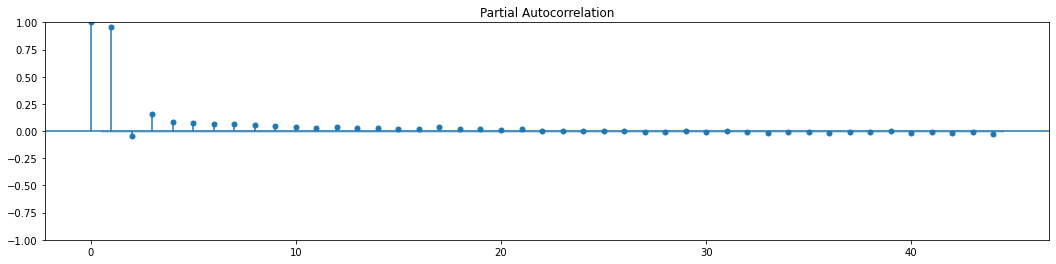

In [475]:
if plot: print(plot_pacf(y_train))

---

# 6. Train Model

In [ ]:
X_train.columns

Index(['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'lag2', 'lag3'],
      dtype='object')

In [ ]:
m2 = LinearRegression()
m2.fit(X_train, y_train)
df_train_model['pred_ar3'] = m2.predict(X_train)

In [ ]:
# df_train_model['trend_seasonal_ar3'] = df_train_model['trend_seasonal'] + df_train_model['result_ar3']
# for year in range(1946,2005):
#     df_train_model[(df_train_model.index>f'{year}-01-01') & (df_train_model.index<f'{year+1}-01-01')][['tg','trend_seasonal_ar3']].plot(title=str(year),alpha=0.7)

In [ ]:
m2.score(X_train, y_train)

0.9128928869857555

In [ ]:
min_year_train = df_train_model.index.min().year
max_year_train = df_train_model.index.max().year + 1
if plot:
    for year in range(min_year_train, max_year_train):
        df_train_model[ (df_train_model.index >= f'{year}-01-01') & (df_train_model.index <= f'{year}-12-31')][['tg','pred_ar3']].plot(alpha=0.7, title=f'{year}')

# 7. Hyperparameter Optimization // Cross-Validation